In [1]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [2]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 331, 331
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
MODEL_SAVE_PATH = "nasnet_large_finetuned.h5"
FEATURE_EXTRACTOR_SAVE_PATH = "nasnet_large_feature_extractor.h5"

In [3]:
def create_data_generators(dataset_path, img_height, img_width, batch_size):
    """
    Creates data generators for training and validation with augmentation.
    """
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        directory=os.path.join(dataset_path, "Train"),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        directory=os.path.join(dataset_path, "Test"),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation"
    )

    return train_generator, validation_generator

In [4]:
def build_model(input_shape, num_classes, learning_rate, momentum):
    """
    Builds and compiles the NASNetLarge model with custom classification layers.
    """
    # Load the pre-trained NASNetLarge model without the top layers
    base_model = NASNetLarge(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the convolutional base

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=SGD(learning_rate=learning_rate, momentum=momentum),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model, base_model

In [5]:
def save_model(model, file_path):
    """
    Saves the trained model to the specified file path.
    """
    try:
        model.save(file_path)
        print(f"Model saved successfully at {file_path}")
    except Exception as e:
        print(f"Error saving model: {e}")


In [6]:
def save_feature_extractor(base_model, file_path):
    """
    Saves the feature extractor (base model) for reuse.
    """
    try:
        base_model.save(file_path)
        print(f"Feature extractor saved successfully at {file_path}")
    except Exception as e:
        print(f"Error saving feature extractor: {e}")

In [7]:
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [8]:
# Dataset path
dataset_path = "/kaggle/input/affectnet-cleaned"


In [9]:
# Create data generators
train_generator, validation_generator = create_data_generators(
    dataset_path, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE
)


Found 8331 images belonging to 6 classes.
Found 914 images belonging to 6 classes.


In [10]:
# Build the model
model, base_model = build_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=train_generator.num_classes,
    learning_rate=LEARNING_RATE,
    momentum=MOMENTUM
)

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Display the model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 331, 331, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 165, 165, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 165, 165, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 165, 165, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 165, 165, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 165, 165, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 169, 169, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 171, 171, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 83, 83, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 84,941,016 (324.02 MB)

 Trainable params: 24,198 (94.52 KB)

 Non-trainable params: 84,916,818 (323.93 MB)

None


In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.2060 - loss: 1.8246 - val_accuracy: 0.3370 - val_loss: 1.6469
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 243s 909ms/step - accuracy: 0.3620 - loss: 1.5985 - val_accuracy: 0.3873 - val_loss: 1.5584
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.3993 - loss: 1.5066 - val_accuracy: 0.3862 - val_loss: 1.5096
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 250s 934ms/step - accuracy: 0.4265 - loss: 1.4446 - val_accuracy: 0.4015 - val_loss: 1.4900
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 245s 916ms/step - accuracy: 0.4335 - loss: 1.4055 - val_accuracy: 0.4289 - val_loss: 1.4486
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 249s 932ms/step - accuracy: 0.4335 - loss: 1.3780 - val_accuracy: 0.4223 - val_loss: 1.4341
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 248s 927ms/step - accuracy: 0.4541 - loss: 1.3434 - val_accuracy: 0.4530 - val_loss: 1.4013
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 250s 936ms/step - accuracy: 0.4599 - loss: 1.3278 - v

In [13]:
# Save the full model
save_model(model, MODEL_SAVE_PATH)

Model saved successfully at nasnet_large_finetuned.h5


In [14]:
# Display the model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 331, 331, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 165, 165, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 165, 165, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 165, 165, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 165, 165, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 165, 165, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 169, 169, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 171, 171, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 83, 83, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 84,965,216 (324.12 MB)

 Trainable params: 24,198 (94.52 KB)

 Non-trainable params: 84,916,818 (323.93 MB)

 Optimizer params: 24,200 (94.54 KB)

None


In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 246s 921ms/step - accuracy: 0.5215 - loss: 1.1253 - val_accuracy: 0.5011 - val_loss: 1.3161
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 248s 926ms/step - accuracy: 0.5180 - loss: 1.1163 - val_accuracy: 0.4759 - val_loss: 1.3404
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 246s 919ms/step - accuracy: 0.5271 - loss: 1.1210 - val_accuracy: 0.4792 - val_loss: 1.3312
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 241s 903ms/step - accuracy: 0.5333 - loss: 1.1121 - val_accuracy: 0.4923 - val_loss: 1.3032
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 244s 913ms/step - accuracy: 0.5197 - loss: 1.1149 - val_accuracy: 0.4912 - val_loss: 1.3316
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 245s 916ms/step - accuracy: 0.5235 - loss: 1.1169 - val_accuracy: 0.4847 - val_loss: 1.3110
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 259s 969ms/step - accuracy: 0.5317 - loss: 1.1033 - val_accuracy: 0.4781 - val_loss: 1.3189
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 248s 927ms/step - accuracy: 0.5269 -

In [16]:
# Save the full model
save_model(model, MODEL_SAVE_PATH)

Model saved successfully at nasnet_large_finetuned.h5


In [17]:
# Save the feature extractor (base model)
save_feature_extractor(base_model, FEATURE_EXTRACTOR_SAVE_PATH)

Feature extractor saved successfully at nasnet_large_feature_extractor.h5


In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 829ms/step - accuracy: 0.5044 - loss: 1.3038
Validation Accuracy: 48.80%


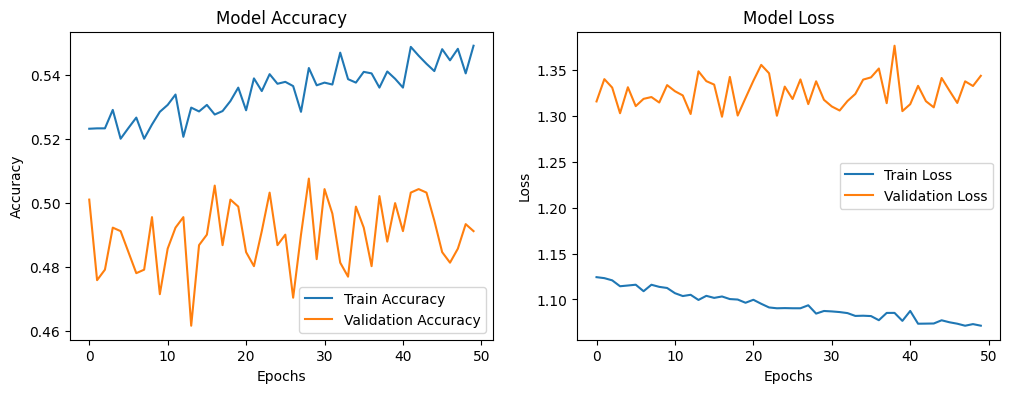

In [19]:
# Plot training history
plot_training_history(history)

In [20]:
train_path = os.path.join(dataset_path, "Train")
test_path = os.path.join(dataset_path, "Test")

print("Train Path:", train_path)
print("Train Path Exists:", os.path.exists(train_path))
print("Test Path:", test_path)
print("Test Path Exists:", os.path.exists(test_path))


Train Path: /kaggle/input/affectnet-cleaned/Train
Train Path Exists: True
Test Path: /kaggle/input/affectnet-cleaned/Test
Test Path Exists: True
